<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Preparation for Model Training #
We noticed some issues with the TrafficCamNet model for our video AI application. It's likely that the model wasn't trained for our exact parking garage use case. For the remaining of the lab, we will use the TAO Toolkit to fine-tune the model so that it can adapt to our environment. Below is what a typical model development workflow looks like. We start by preparing a pre-trained model and the data. Next, we prepare the configuration file(s) and begin to train the model with new data and evaluate its performance. We export the model once its satisfactory. Note that this does not include inference optimization steps, which is very important for video AI applications that are deployed on edge devices. 
<p><img src='images/pre-trained_model_workflow.png' width=1080></p>

## Learning Objectives ##
In this notebook, you will learn how to prepare for training a video AI model using the TAO Toolkit, including: 
* Understanding Model Specification
* Preparing Data for TAO Toolkit Consumption
* Editing Spec Files for TAO Toolkit Tasks

**Table of Contents**<br>
This notebook covers the below sections: 
1. [Detectnet_v2 Object Detection Model](#s1)
    * [Directory Structure](#s1.1)
    * [Model Objective](#s1.2)
2. [Prepare Pre-trained Model](#s2)
    * [Exercise #1 - Review Model Card](#e1)
3. [Prepare Data Set](#s3)
    * [Annotation](#s3.1)
    * [Exploratory Data Analysis](#s3.2)
    * [Covert Video File into Frame Images](#s3.3)
    * [Generate Labels](#s3.4)
    * [Converting to TFRecords](#s3.5)
    * [Exercise #2 Dataset Convert](#e2)

<a name='s1'></a>
## DetectNet_v2 Object Detection Model ##
As we previously learned, the [TrafficCamNet](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_trafficcamnet) purpose-built model is based on NVIDIA DetectNet_v2 detector with ResNet18 as a feature extractor. As such, we will use the `detectnet_v2` task, which supports the following subtasks: 
* `dataset_convert`
* `train`
* `evaluate`
* `inference`
* `prune`
* `calibration_tensorfile`
* `export`

<p><img src='images/rewind.png' width=720><p>
    
These subtasks can be invoked using the convention `detectnet_v2 <subtask> <args_per_subtask>` on the command-line. Additionally, we can always find more information about these subtasks with `detector_v2 <subtask> --help`. 

<a name='s1.1'></a>
### Directory Structure ###
We will use the below structure for our project, where the `tao_project` directory will hold most of the assets related to model training and outputs. 

<p><img src='images/project_structure.png' width=740></p>

* The current directory is `/dli/task`. When using paths, it is most reliable to use the absolute path that begins with `/dli/task` as some of the functions will otherwise try to reference the paths relative to where they are called. 
* The higher level `data` directory represents the raw video data, vs. the lower level `tao_project/data` directory represents the preprocessed data to be used for model training. 
* The higher level `images` directory contains graphics used in this course and are not related to the video AI model. 
* The `spec_files` directory holds spec files that will be used for TAO Toolkit model training as well as DeepStream `Gst-nvinfer` plugin configuration files. 
* The `tao_project/models` directory will hold different versions of the model as we work to arrive at a final, optimized, product. Each folder will hold the corresponding model file (e.g. `.tlt` or `.etlt`), as well as accompanied assets such as `labels.txt`. 

Execute the below cell to set and create directories for the TAO Toolkit. 

In [109]:
# DO NOT CHANGE THIS CELL
# Set and create directories for the TAO Toolkit experiment
import os

os.environ['PROJECT_DIR']='/dli/task/tao_project'
os.environ['SOURCE_DATA_DIR']='/dli/task/data'
os.environ['DATA_DIR']='/dli/task/tao_project/data'
os.environ['MODELS_DIR']='/dli/task/tao_project/models'
os.environ['SPEC_FILES_DIR']='/dli/task/spec_files'

!mkdir $PROJECT_DIR
!mkdir $DATA_DIR
!mkdir $MODELS_DIR

mkdir: cannot create directory ‘/dli/task/tao_project’: File exists
mkdir: cannot create directory ‘/dli/task/tao_project/data’: File exists
mkdir: cannot create directory ‘/dli/task/tao_project/models’: File exists


<a name='s1.2'></a>
### Model Objective ###
For our video AI application, we want to train a model that uses the TrafficCamNet as the starting point and provide it with additional (labeled) data so it can adapt to our specific camera angle, lighting condition, and other environmental conditions. We will be using the **unpruned pre-trained TrafficCamNet purpose-built model** as the starting point and training a custom **one-class Object Detection model** that is adapted to our use case. 

<a name='s2'></a>
## Prepare Pre-trained Model and Data Set ##
Developers typically begin by choosing and downloading a pre-trained model from [NGC](https://ngc.nvidia.com/) - either a highly accurate purpose-built model or just the pre-trained weights of the architecture of their choice. It's difficult to immediately identify which model/architecture will work best for a specific use case as there is often a tradeoff between time to train, accuracy, and inference performance. It is common to compare across multiple models before picking the best candidate.

Here are some pointers that will help choose an appropriate model: 
* Look at the model inputs/outputs to decide if it will fit your use case. 
* Input format is also an important consideration. For example, TrafficCamNet, as well as other DetectNet_v2 models, expect the input to be 0-1 normalized with input channels in RGB order. Models that use a BGR order will require input preprocessing/mean subtraction that might result in suboptimal performance. 

We can use the `ngc registry model list <model_glob_string>` command to get a list of models that are hosted in the NGC model registry. For example, we can use `ngc registry model list nvidia/tao/*` to list all available models. The `--column` option identifies the columns of interest. More information about the NGC Registry CLI can be found in the [User Guide](https://docs.nvidia.com/dgx/pdf/ngc-registry-cli-user-guide.pdf). For each model, there is a pruned version that can be deployed as is or an unpruned version which can be used to re-train with more data for specific use cases. We will use the unpruned version as a start for training purposes. The `ngc registry model download-version <org>/[<team>/]<model-name:version>` command will download the model from the registry. It has a `--dest` option to specify the path to download directory. 

<a name='e1'></a>
#### Exercise #1 - Review Model Cards ####
Let's download a pre-trained model. 

**Instructions**:<br>
* Review the model cards for [TrafficCamNet](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_trafficcamnet) and/or [DetectNet_v2](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_pretrained_detectnet_v2) models to understand where you can find important model specifications. 
* Execute the below cell to download the NGC CLI. 
* Execute the following cell to list all available models. 
* Execute the following cell to download the TrafficCamNet model. 
* Execute the following cell to check if the model has been downloaded. 
* Execute the following cell to create `labels.txt` if it doesn't exist. 

In [110]:
# DO NOT CHANGE THIS CELL
# Download the NGC CLI
%env CLI=ngccli_cat_linux.zip
!mkdir -p ngc_assets/ngccli
!wget "https://ngc.nvidia.com/downloads/$CLI" -P ngc_assets/ngccli
!unzip -u "ngc_assets/ngccli/$CLI" \
       -d ngc_assets/ngccli/
!rm ngc_assets/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli/ngc-cli:{}".format("ngc_assets", os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2022-08-29 18:52:51--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 18.165.83.53, 18.165.83.59, 18.165.83.111, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|18.165.83.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34014460 (32M) [application/zip]
Saving to: ‘ngc_assets/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  32.44M  --.-KB/s    in 0.1s    

2022-08-29 18:52:51 (225 MB/s) - ‘ngc_assets/ngccli/ngccli_cat_linux.zip’ saved [34014460/34014460]

Archive:  ngc_assets/ngccli/ngccli_cat_linux.zip


In [111]:
# DO NOT CHANGE THIS CELL
# List all available models
!ngc registry model list nvidia/tao/* --column name --column repository --column application

+-------------------------+-------------------------+-------------------------+
| Name                    | Repository              | Application             |
+-------------------------+-------------------------+-------------------------+
| RIVA Conformer ASR      | nvidia/tao/speechtotext | Speech to Text          |
| Mandarin                | _zh_cn_conformer        |                         |
| RIVA Punctuation and    | nvidia/tao/punctuationc | Punctuation and         |
| Capitalization for      | apitalization_es_us_ber | Capitalization          |
| Spanish                 | t_base                  |                         |
| RIVA Punctuation and    | nvidia/tao/punctuationc | Punctuation and         |
| Capitalization for      | apitalization_de_de_ber | Capitalization          |
| German                  | t_base                  |                         |
| TAO Pretrained          | nvidia/tao/pretrained_e | Object Detection        |
| EfficientDet            | fficientdet 

In [112]:
# DO NOT CHANGE THIS CELL
# Download the unpruned pre-trained model from NGC
!ngc registry model download-version nvidia/tao/peoplenet:unpruned_v1.0 \
    --dest $MODELS_DIR

Downloaded 85.32 MB in 6s, Download speed: 14.2 MB/s                
--------------------------------------------------------------------------------
   Transfer id: peoplenet_vunpruned_v1.0
   Download status: Completed
   Downloaded local path: /dli/task/tao_project/models/peoplenet_vunpruned_v1-1.0
   Total files downloaded: 1
   Total downloaded size: 85.32 MB
   Started at: 2022-08-29 18:53:11.118272
   Completed at: 2022-08-29 18:53:17.129269
   Duration taken: 6s
--------------------------------------------------------------------------------


In [113]:
# DO NOT CHANGE THIS CELL
# Download the pruned pre-trained model from NGC
!ngc registry model download-version nvidia/tao/peoplenet:pruned_v1.0 \
    --dest $MODELS_DIR

Downloaded 11.3 MB in 3s, Download speed: 3.77 MB/s               
-------------------------------------------------------------------------------
   Transfer id: peoplenet_vpruned_v1.0
   Download status: Completed
   Downloaded local path: /dli/task/tao_project/models/peoplenet_vpruned_v1-1.0
   Total files downloaded: 2
   Total downloaded size: 11.3 MB
   Started at: 2022-08-29 18:53:24.281060
   Completed at: 2022-08-29 18:53:27.285857
   Duration taken: 3s
-------------------------------------------------------------------------------


In [114]:
# DO NOT CHANGE THIS CELL
# Check if models have been downloaded into directory
!ls -rlt $MODELS_DIR

total 16
drwx------ 2 root root 4096 Aug 29 18:39 peoplenet_vunpruned_v1.0
drwx------ 2 root root 4096 Aug 29 18:39 peoplenet_vpruned_v1.0
drwx------ 2 root root 4096 Aug 29 18:53 peoplenet_vunpruned_v1-1.0
drwx------ 2 root root 4096 Aug 29 18:53 peoplenet_vpruned_v1-1.0


**Observations**:<br>
Below are some fields that are important to note: 

<p><img src='images/model_card_tao.png' width=1080></p>

<p><img src='images/encryption_key.png' width=540></p>

<p><img src='images/important.png' width=720></p>

_Note that we're using the purpose-built TrafficCamNet model as the starting point for scene adaptation. Feel free to try the lab with other model architectures if there is time left at the end of the course. When working with purpose-built models from NGC, the correct **encryption key** is required to load the model. Users will be able to define their own export encryption key when training from a general purpose model. This is to protect proprietary IP and used to decrypt the `.etlt` model in DeepStream applications._

<a name='s3'></a>
## Prepare Data Set ##
We're going to use annotated video data shot from the same camera at the NVIDIA headquarters parking lot for our model. It's important to recognize that the data that we're providing is limited and insufficient for training a model from scratch. Using the TAO Toolkit and transfer learning, we can use the TrafficCamNet model as the starting point and train a custom model. This is a common case when we can leverage TAO Toolkit's scene/domain adaptation capabilities. 

The TAO Toolkit requires the data to be in a specific format for training and evaluation: 
* The object detection tasks in the TAO Toolkit expects data in the `KITTI format`. 
    * The `images` directory contains the images to train on. 
    * The `labels` directory contains labels to the corresponding images. 
    * The `kitti_seq_to_map.json` file is _optional_ and contains a sequence to frame ID mapping for the frames in the images directory. It is useful if the data needs to be split into folds sequence wise. 

<p><img src='images/detection_input.png' width=720></p>

* For comparison, the classification tasks expects a directory of images with the following structure, where each class has its own directory with the class name. 

<p><img src='images/classification_input.png' width=720></p>

_You can find more details on data annotation format in the [TAO Toolkit User Guide](https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/data_annotation_format.html#object-detection-kitti-format)_. 

<a name='s3.1'></a>
### Annotation ###
Let's preview the video before moving forward. 

Execute the below cell to view the video. 

In [185]:
# DO NOT CHANGE THIS CELL
# View the video
from IPython.display import Video

Video("data/VID-20220829-WA0021.mp4", width=720)

In addition to video feeds, we need labels to evaluate the inference results (compare the actual objects to those detected by our deep learning models), and also to expand the ground truth for training purposes. This is normally a time consuming process, but this requirement is significantly reduced with transfer learning. There are a number of annotation tools that are publically available for use. Our data set annotation was generated (manually) using [Vatic](https://github.com/cvondrick/vatic) and provided in JSON format. Each entry starts with the `track_id`, representing a unique index for each person within the recording. The `track_id` provides a set of bounding boxes and their respective bounding box positions. Below, you can see elements of the annotation format:

<p><img src="images/vatic.jpg" width=720></p>

This is a snapshot of the JSON file for the video. We're mainly interested in the bounding box coordinates captured for our object detection model: 
* **xbr**: an integer in the range between [0, frame width], indicating the right-most location of the bounding box in coordinates relative to the frame size.<br />
* **xtl**: an integer in the range between [0, frame width], indicating the left-most location of the bounding box in coordinates relative to the frame size.<br />
* **ybr**: an integer in the range between [0, frame height], indicating the bottom-most location of the bounding box in coordinates relative to the frame size.<br />
* **ytl**: an integer in the range between [0, frame height], indicating the top-most location of the bounding box in coordinates relative to the frame size.<br />
<p><img src="images/json_structure.png" width=720></p>

Execute the cell below to preview the annotation in JSON format. 

In [186]:
# DO NOT CHANGE THIS CELL
# Preview the annotation
!cat $SOURCE_DATA_DIR/126_206-A0-3_json_sample.txt

{"0": {"boxes": {"0": {"occluded": 0, "ybr": 27, "ytl": 15, "xbr": 310, "outside": 1, "attributes": [], "xtl": 290}, "1": {"occluded": 0, "ybr": 26, "ytl": 14, "xbr": 309, "outside": 1, "attributes": [], "xtl": 289}, "2": {"occluded": 0, "ybr": 26, "ytl": 14, "xbr": 309, "outside": 1, "attributes": [], "xtl": 289}, "3": {"occluded": 0, "ybr": 26, "ytl": 14, "xbr": 309, "outside": 1, "attributes": [], "xtl": 289}, "4": {"occluded": 0, "ybr": 26, "ytl": 14, "xbr": 308, "outside": 1, "attributes": [], "xtl": 289}, "5": {"occluded": 0, "ybr": 26, "ytl": 14, "xbr": 308, "outside": 1, "attributes": [], "xtl": 289}, "6": {"occluded": 0, "ybr": 25, "ytl": 14, "xbr": 308, "outside": 1, "attributes": [], "xtl": 289}, "7": {"occluded": 0, "ybr": 25, "ytl": 14, "xbr": 308, "outside": 1, "attributes": [], "xtl": 289}, "8": {"occluded": 0, "ybr": 25, "ytl": 14, "xbr": 307, "outside": 1, "attributes": [], "xtl": 289}, "9": {"occluded": 0, "ybr": 25, "ytl": 14, "xbr": 307, "outside": 1, "attributes": 

<a name='s3.2'></a>
### Exploratory Data Analysis ###
We can analyze and preprocess the data using the [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). We went ahead and converted the JSON files into a .csv text file for this purpose since it's otherwise a time consuming process. 

Execute the below cells to analyze the data contained in the annotation file. 

In [194]:
# DO NOT CHANGE THIS CELL
# Load the .csv into a DataFrame
import ast
import pandas as pd

annotated_frames=pd.read_csv('data/annov2.csv', converters={2:ast.literal_eval})
print("Length of the full DF object:", len(annotated_frames))
annotated_frames.head()

Length of the full DF object: 20


,attributes,camera,crop,frame_no,label,occluded,outside,track_id,xmax,xmin,ymax,ymin
0,people,126_206-A0-3,"(0, 0, 0, 0)",11,People,0,1,0,305,158,473,67
1,people,126_206-A0-3,"(0, 0, 0, 0)",12,People,0,1,0,689,594,277,62
2,people,126_206-A0-3,"(0, 0, 0, 0)",13,People,0,1,0,305,158,473,67
3,people,126_206-A0-3,"(0, 0, 0, 0)",14,People,0,1,0,305,158,473,67
4,people,126_206-A0-3,"(0, 0, 0, 0)",15,People,0,1,0,305,158,473,67


We can do a `DataFrame.groupby().size()` to see how many rows there are per `frame_no`. 

In [195]:
# DO NOT CHANGE THIS CELL
# Check how many rows per frame_no
annotated_frames.groupby('frame_no').size()

frame_no
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
dtype: int64

In [196]:
# DO NOT CHANGE THIS CELL
# include annotations that do not have person inside the bbox
filtered_frames=annotated_frames[annotated_frames["outside"] == 1]
print("Length of the filtered DF object:", len(filtered_frames))
filtered_frames.head()

Length of the filtered DF object: 20


,attributes,camera,crop,frame_no,label,occluded,outside,track_id,xmax,xmin,ymax,ymin
0,people,126_206-A0-3,"(0, 0, 0, 0)",11,People,0,1,0,305,158,473,67
1,people,126_206-A0-3,"(0, 0, 0, 0)",12,People,0,1,0,689,594,277,62
2,people,126_206-A0-3,"(0, 0, 0, 0)",13,People,0,1,0,305,158,473,67
3,people,126_206-A0-3,"(0, 0, 0, 0)",14,People,0,1,0,305,158,473,67
4,people,126_206-A0-3,"(0, 0, 0, 0)",15,People,0,1,0,305,158,473,67


The filtered DataFrame is much smaller. We can plot the _Frame Indices that Include Moving people_. 

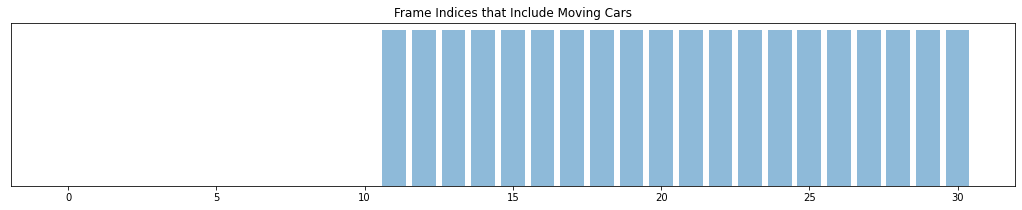

In [197]:
# DO NOT CHANGE THIS CELL
# Plot frames that include moving people
import matplotlib.pyplot as plt
import numpy as np

frames_list=list(filtered_frames['frame_no'].unique())
frame_existance=np.zeros(annotated_frames['frame_no'].max()+1)
for i in frames_list:
    frame_existance[int(i)]=1
y_pos=np.arange(len(frame_existance))
fig, ax=plt.subplots(figsize=(18, 3))
plt.bar(y_pos, frame_existance, align='center', alpha=0.5)
plt.title('Frame Indices that Include Moving People')
plt.yticks([])
plt.show()

<a name='s3.3'></a>
### Convert Video File into Frame Images ###
Because the object detection model operates on frame-based data, we will need to generate frames from the original movie file. To do so, we are going to use [OpenCV](https://opencv.org/) to open the video file and write a `.png` image file for each frame that has annotation. We will be using the original `.mp4` file at 10 FPS. In addition to converting video frames into `.png` images, we are creating a video for which the annotations are displayed as bounding boxes. 

Execute the below cells to create an annotated video and extract annotated images for the TAO Toolkit. This can take up to 5 mins. 

In [198]:
# DO NOT CHANGE THIS CELL
# Define function to extract images and generate an annotated video
import cv2
colors = [(255, 255, 0), (255, 0, 255), (0, 255, 255), (0, 0, 255), (255, 0, 0), (0, 255, 0), (0, 0, 0), (255, 100, 0), (100, 255, 0), (100, 0, 255), (255, 0, 100)]

def save_images(video_path, image_folder, frames_list, annotated_frames,  video_out_folder, fps=10):
    # Create image folder if it doesn't exist
    if not os.path.exists(image_folder):
        print("Creating images folder")
        os.makedirs(image_folder)
    
    # Create directory for output video
    if not os.path.exists(video_out_folder):
        print("Creating video out folder")
        os.makedirs(video_out_folder)
    
    # Start reading input video
    input_video=cv2.VideoCapture(video_path)
    
    # cv2.VideoCapture().read() returns true if it has a next frame
    retVal, im=input_video.read()
    size=im.shape[1], im.shape[0]
    fourcc=cv2.VideoWriter_fourcc('h','2','6','4') 
    
    # Start writing output video
    output_video=cv2.VideoWriter('{}/annotated_video.mp4'.format(video_out_folder), fourcc, fps, size)

    frameCount=0
    i=1
    
    # While has next frame
    while retVal:
        print("\rProcessing frame no: {}".format(frameCount), end='', flush=True)
        
        # If current frame is in the list of annotated frames, draw bounding box(es) and include in the output video
        if frameCount in frames_list:
            print("\rSaving frame no: {}, index: {} out of {}".format(frameCount, i, len(frames_list)), end='')
            cv2.imwrite(os.path.join(image_folder, '{}.png'.format(frameCount)), im)
            i+=1
            frame_items=annotated_frames[annotated_frames["frame_no"]==int(frameCount)]
            for index, box in frame_items.iterrows():
                xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
                xmin2, ymin2, xmax2, ymax2 = box["crop"][0], box["crop"][1], box["crop"][2], box["crop"][3]
                cv2.rectangle(im, (xmin, ymin), (xmax, ymax), colors[0], 1)
                cv2.rectangle(im, (int(xmin2), int(ymin2)), (int(xmax2), int(ymax2)), colors[1], 1)
            output_video.write(im)

        # Read next frame
        retVal, im=input_video.read()
        frameCount+=1

    input_video.release()
    output_video.release()
    return size        

In [199]:
# DO NOT CHANGE THIS CELL
# Extract images and generate an annotated video
save_images('{}/VID-20220829-WA0021.mp4'.format(os.environ['SOURCE_DATA_DIR']), 
            '{}/{}'.format('{}/training'.format(os.environ['DATA_DIR']), 'images'),
            frames_list,
            filtered_frames,
            '{}/{}'.format(os.environ['DATA_DIR'], 'video_out'))

Processing frame no: 159ex: 20 out of 20

(848, 480)

In [200]:
# DO NOT CHANGE THIS CELL
# View the annotated output video
from IPython.display import Video
Video('tao_project/data/video_out/annotated_video.mp4', width=720)

<a name='s3.4'></a>
### Generate Labels ###
We also need to generate KITTI format labels for each frame, which is also described in the [TAO Toolkit User Guide](https://docs.nvidia.com/tao/tao-toolkit/text/data_annotation_format.html#label-files). A KITTI format label file is a simple text file containing one line per object. Each line has multiple fields. The sum of the total number of elements per object is 15 as shown below: <br>
`class name`, `truncation`, `occlusion`, `alpha`, `xmin`, `ymin`, `xmax`, `ymax`, `height`, `weight`, `length`, `x`, `y`, `z`, `rotation_y` <br>
Currently, for detection the TAO Toolkit only requires the class name and bbox coordinates fields to be populated. This is because the TAO Toolkit training pipe supports training only for class and bbox coordinates. The remaining fields may be set to 0 as placeholder. 

Execute the below cells to generate the labels. 

In [15]:
# DO NOT CHANGE THIS CELL
# Generate labels in KITTI format
label_folder='{}/training/labels'.format(os.environ['DATA_DIR'])
if not os.path.exists(label_folder):
    print("Creating labels folder")
    os.makedirs(label_folder)
for frame in sorted(frames_list): 
    current_frame=filtered_frames[filtered_frames['frame_no']==frame]
    with open('{}/{}.txt'.format(label_folder, frame), 'w') as f: 
        for i, box in current_frame.iterrows(): 
            print('Writing for frame {}'.format(frame), end='\r')
            f.write("Car 0 0 0 {} {} {} {} 0 0 0 0 0 0 0\n".format(box['xmin'], box['ymin'], box['xmax'], box['ymax']))

Creating labels folder


In [ ]:
# DO NOT CHANAGE THIS CELL
# Preview sample KITTI format labels
!cat $DATA_DIR/training/labels/20.txt

<a name='s3.5'></a>
### Converting to TFRecords ###
The TAO Toolkit enables converting the training data into the [**TFRecords**](https://www.tensorflow.org/tutorials/load_data/tfrecord) format, which is a simple format for storing a sequence of binary records. The TFRecord specification encodes an image frame and all the annotations associated with that frame into a single row. This can drastically help iterate faster through the data. The TAO Toolkit helps us easily convert data to TFRecord format once it's in the KITTI format. This can be done using the `dataset_convert` subtask. The `dataset_convert` tool requires a configuration file as input, which has the below parameters: 
* `kittie_config`
    * `root_directory_path (str)`: Path to the data set root. 
    * `image_dir_name (str)`: Relative path to the directory containing images. 
    * `label_dir_name (str)`: Relative path to the directory containing labels. 
    * `partition_mode (str)`: Method _("random" or "sequence")_ employed when partitioning the data into folds. 
    * `num_partitions (int)`: Number of partitions (folds) to split the data _(default=2)_. This field is ignored when the partition mode is set to "random" as by default only two partitions are generated: `train` and `val`. 
    * `image_extension (str)`: Extension of the images _(".png", ".jpg", or ".jpeg")_. 
    * `val_split (float)`: Percentage of data to be separated for validation _(0-100)_. 
    * `num_shards (int)`: The number of shards per fold _(1-20)_. When you have large amounts of samples, it is beneficial to shard your data set into multiple files as it allows inputs to 1) be read in parallel to improve throughput and 2) be shuffled better to improve performance of the model. This is particularly important when the data set is large. You can find more information on sharding on [TensorFlow's API documentation](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset#raises_1). 
* `image_directory_path (str)`: Path to the data set root. 

Once generated, you can use the TFRecords across multiple training experiments. 

<a name='e2'></a>
#### Exercise #2 - Dataset Convert ####
Let's use the `dataset_convert` subtask to generate TFRecords. 

**Instructions**:<br>
* Modify the [TFRecords conversion spec file](spec_files/kitti_config.txt) by changing the `<FIXME>`s into the correct values and **save changes**. 
* Execute the below cells to create TFRecords. 

In [ ]:
# DO NOT CHANGE THIS CELL
# View the spec file
!cat $SPEC_FILES_DIR/kitti_config.txt

In [ ]:
# kitti_config {
#   root_directory_path: "/dli/task/tao_project/data/training"
#   image_dir_name: "images"
#   label_dir_name: "labels"
#   image_extension: ".png"
#   partition_mode: "random"
#   num_partitions: 2
#   val_split: 20
#   num_shards: 10
# }
# image_directory_path: "/dli/task/tao_project/data/training"

Click ... to show **solution**. 

In [ ]:
# DO NOT CHANGE THIS CELL
# View dataset_convert usage
!detectnet_v2 dataset_convert --help

When using the `dataset_convert` subtask, the `-o` argument indicates the output filename and the `-d` argument points to the path to the detection data set spec file containing the config for exporting `.tfrecord` files. 

In [ ]:
# DO NOT CHANGE THIS CELL
# Create directory for TFRecords and delete existing files if they exist
!mkdir -p $DATA_DIR/tfrecords && rm -rf $DATA_DIR/tfrecords/*

!detectnet_v2 dataset_convert -d $SPEC_FILES_DIR/kitti_config.txt \
                              -o $DATA_DIR/tfrecords/kitti_trainval/kitti_trainval

Check the shards that have been created. 

In [ ]:
# DO NOT CHANGE THIS CELL
# Check the shards that have been created
!ls -rlt $DATA_DIR/tfrecords/kitti_trainval/

**Well Done**! When you're ready, let's move to the [next notebook](./03_model_training_with_the_TAO_Toolkit.ipynb). 

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>